In [17]:
import numpy as np
import cv2
import os, shutil
from shutil import copyfile
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation
from keras.layers import UpSampling2D, Conv2DTranspose, Concatenate 
from keras.layers import Activation
from keras.layers.activation import LeakyReLU, PReLU, ELU
from keras.layers import Flatten, Reshape, Lambda, BatchNormalization, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

In [4]:
base_dir = '/kaggle/input/landscape-image-colorization/landscape Images'
color_dir = os.path.join(base_dir, 'color')
gray_dir = os.path.join(base_dir, 'gray')

In [9]:
data_dir = '/kaggle/working'

os.mkdir(os.path.join(data_dir, 'train'))
os.mkdir(os.path.join(data_dir, 'val'))
os.mkdir(os.path.join(data_dir, 'test'))

os.mkdir(os.path.join(data_dir, 'train', 'color'))
os.mkdir(os.path.join(data_dir, 'train', 'color', 'color'))
os.mkdir(os.path.join(data_dir, 'val', 'color'))
os.mkdir(os.path.join(data_dir, 'val', 'color', 'color'))
os.mkdir(os.path.join(data_dir, 'test', 'color'))
os.mkdir(os.path.join(data_dir, 'test', 'color', 'color'))

os.mkdir(os.path.join(data_dir, 'train', 'gray'))
os.mkdir(os.path.join(data_dir, 'train', 'gray', 'gray'))
os.mkdir(os.path.join(data_dir, 'val', 'gray'))                      
os.mkdir(os.path.join(data_dir, 'val', 'gray', 'gray'))
os.mkdir(os.path.join(data_dir, 'test', 'gray'))
os.mkdir(os.path.join(data_dir, 'test', 'gray', 'gray'))

try: 
    os.remove(os.path.join(data_dir, '__notebook_source__.ipynb'))
    os.remove(os.path.join(data_dir, '.virtual_documents'))
except:
    pass

os.listdir(data_dir)

['train', 'val', 'test']

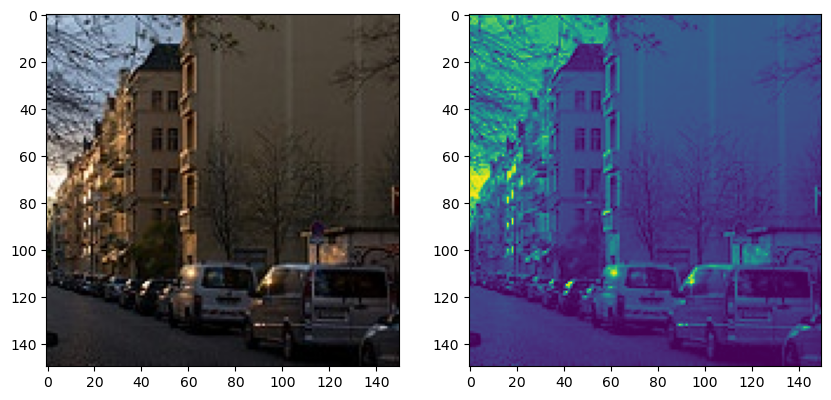

(150, 150, 3) (150, 150, 1)


In [10]:
color_img = plt.imread(os.path.join(color_dir, '0.jpg'))
gray_img = plt.imread(os.path.join(gray_dir, '0.jpg'))

gray_img = gray_img.reshape((gray_img.shape[0], gray_img.shape[1], 1))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(color_img)
ax[1].imshow(gray_img)
plt.show()

print(color_img.shape, gray_img.shape)

In [11]:
def split_data(source, split_size):
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + "is zero length, so ignoring.")
    
    training_length = int(len(files) * split_size)
    validation_length = int(len(files) * (1 - split_size) / 2)
    testing_length = int(len(files) * (1 - split_size) / 2)
    
    shuffled_set = random.sample(files, len(files))
    
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length + validation_length]
    testing_set = shuffled_set[training_length + validation_length:]
    
    return training_set, validation_set, testing_set

def copy_data(source, destination, files):
    with tqdm(total = len(files)) as pbar:
        for filename in files:
            source_file = os.path.join(source, filename)
            destination_file = os.path.join(destination, filename)
            copyfile(source_file, destination_file)
            pbar.update(1)

training_set, validation_set, testing_set = split_data(gray_dir+'/', 0.8)

copy_data(gray_dir, os.path.join(data_dir, 'train', 'gray', 'gray'), training_set)
copy_data(gray_dir, os.path.join(data_dir, 'val', 'gray', 'gray'), validation_set)
copy_data(gray_dir, os.path.join(data_dir, 'test', 'gray', 'gray'), testing_set)

copy_data(color_dir, os.path.join(data_dir, 'train', 'color', 'color'), training_set)
copy_data(color_dir, os.path.join(data_dir, 'val', 'color', 'color'), validation_set)
copy_data(color_dir, os.path.join(data_dir, 'test', 'color', 'color'), testing_set)

100%|██████████| 714/714 [00:04<00:00, 147.67it/s]


In [44]:
seed = 24
image_datagen = ImageDataGenerator(rescale=1./255)

def generator(generator, directory, color_mode, seed, batch_size = 32):
    return generator.flow_from_directory(
        directory,
        target_size=(150, 150),
        color_mode = color_mode,
        batch_size=batch_size,
        class_mode=None,
        seed=seed
    )

COLOR_MODE_X = 'grayscale'
COLOR_MODE_Y = 'rgb' 

train_X_generator  = generator(image_datagen, os.path.join(data_dir, 'train', 'gray'), COLOR_MODE_X, seed)
train_Y_generator  = generator(image_datagen, os.path.join(data_dir, 'train', 'color'), COLOR_MODE_Y, seed)

val_X_generator  = generator(image_datagen, os.path.join(data_dir, 'val', 'gray'), COLOR_MODE_X, seed)
val_Y_generator  = generator(image_datagen, os.path.join(data_dir, 'val', 'color'), COLOR_MODE_Y, seed)

def myImageGenerator(grey_generator, image_generator):
    train_generator = zip(grey_generator, image_generator)
    for (gray, img) in train_generator:
        yield (gray, img)

train_generator = myImageGenerator(train_X_generator, train_Y_generator)
val_generator = myImageGenerator(val_X_generator, val_Y_generator)

Found 5703 images belonging to 1 classes.
Found 5703 images belonging to 1 classes.
Found 712 images belonging to 1 classes.
Found 712 images belonging to 1 classes.


(32, 150, 150, 1) (32, 150, 150, 3)


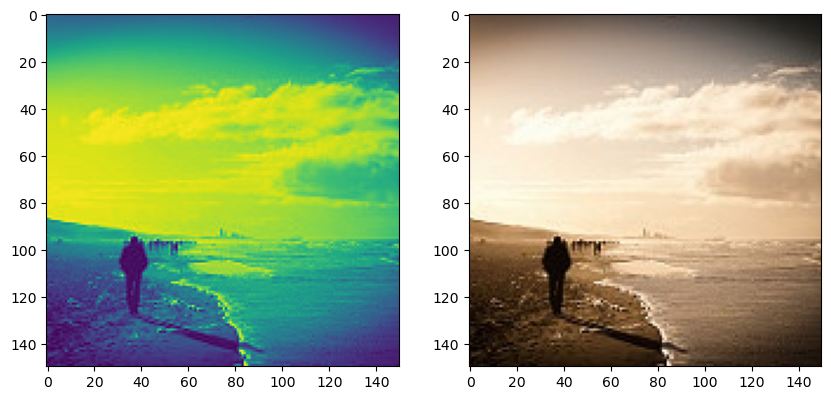

In [13]:
gray_img, color_img = next(train_generator)

print(gray_img.shape, color_img.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gray_img[0])
ax[1].imshow(color_img[0])
plt.show()

In [15]:
class Unet(keras.Model):
    
    def __init__(self, input_dim, 
                 use_batchnorm=True, 
                 use_dropout=False, 
                 **kwargs):
        
        super(Unet, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.built = True
        self.model = None

    def conv_block(self, input, num_filters):
        x = Conv2D(num_filters, 3, padding='same')(input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(num_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x

    def encoder_block(self, input, num_filters, pulingsize):
        x = self.conv_block(input, num_filters)
        p = MaxPooling2D((pulingsize, pulingsize))(x)
        return x, p

    def decoder_block(self, input, residual_blocs, num_filters, upsamplingsize):
        x = UpSampling2D((upsamplingsize, upsamplingsize))(input)
        x = Concatenate()([x, residual_blocs])
        x = self.conv_block(x, num_filters)
        return x

    def build_unet(self):

        """ Input """
        inputs = Input(self.input_dim)

        """ Encoder """
        s1, p1 = self.encoder_block(inputs, 32, 2)
        s2, p2 = self.encoder_block(p1, 64, 5)
        s3, p3 = self.encoder_block(p2, 128, 1)

        """ Bridge """
        b1 = self.conv_block(p3, 1024)

        """ Decoder """
        d1 = self.decoder_block(b1, s3, 128, 1)                
        d2 = self.decoder_block(d1, s2, 64, 5)                     
        d3 = self.decoder_block(d2, s1, 32, 2)                                       
        """ Output """
        outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d3)

        self.model = Model(inputs, outputs)
    
    def call(self, inputs):
        return self.model(inputs)

In [ ]:
unet_model = Unet(input_dim=(150, 150, 1))

unet_model.build_unet()
unet_model.model.summary()

In [ ]:
os.mkdir(os.path.join(data_dir, "saved_models"))

In [19]:
unet_model.model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

models_names = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
filepath_checkpoint = os.path.join(data_dir, "saved_models", models_names)
checkpoint = ModelCheckpoint(filepath=filepath_checkpoint, save_best_only=False)

calbacks = [checkpoint]

unet_model.model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
)

Epoch 1/100
100/100 [==============================] - 30s 188ms/step - loss: 0.0237 - mae: 0.1126 - val_loss: 0.0761 - val_mae: 0.2342
Epoch 2/100
100/100 [==============================] - 19s 194ms/step - loss: 0.0103 - mae: 0.0752 - val_loss: 0.0626 - val_mae: 0.2118
Epoch 3/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0083 - mae: 0.0661 - val_loss: 0.0507 - val_mae: 0.1901
Epoch 4/100
100/100 [==============================] - 18s 183ms/step - loss: 0.0073 - mae: 0.0619 - val_loss: 0.0331 - val_mae: 0.1508
Epoch 5/100
100/100 [==============================] - 16s 163ms/step - loss: 0.0069 - mae: 0.0588 - val_loss: 0.0158 - val_mae: 0.1018
Epoch 6/100
100/100 [==============================] - 19s 186ms/step - loss: 0.0068 - mae: 0.0587 - val_loss: 0.0078 - val_mae: 0.0661
Epoch 7/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0062 - mae: 0.0557 - val_loss: 0.0065 - val_mae: 0.0577
Epoch 8/100
100/100 [===========================

In [22]:
unet_model.model.evaluate(test_generator, steps = 200)

200/200 [==============================] - 12s 59ms/step - loss: 0.0052 - mae: 0.0479


[0.005230423528701067, 0.047945860773324966]

In [53]:
test_X_generator  = generator(image_datagen, os.path.join(data_dir, 'test', 'gray'), COLOR_MODE_X, seed, batch_size = 1)
test_Y_generator  = generator(image_datagen, os.path.join(data_dir, 'test', 'color'), COLOR_MODE_Y, seed, batch_size = 1)

test_generator = myImageGenerator(test_X_generator, test_Y_generator)


Found 714 images belonging to 1 classes.
Found 714 images belonging to 1 classes.


1/1 [==============================] - 0s 18ms/step
(1, 150, 150, 3)


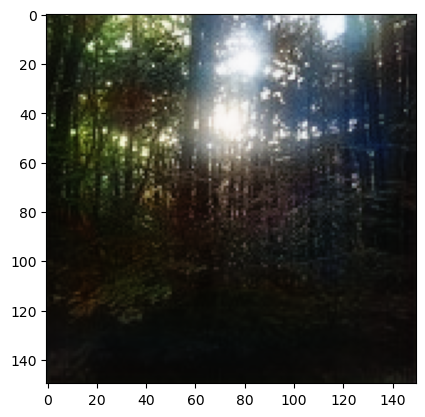

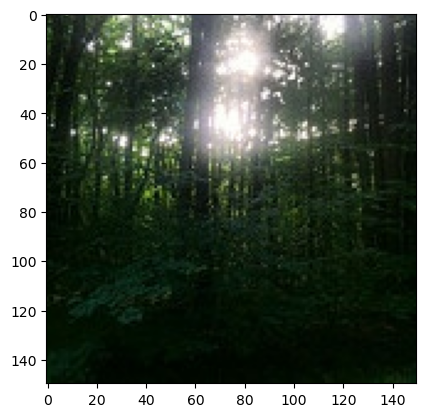

In [61]:
gen = test_generator.__next__()

y_pred = unet_model.model.predict(gen[0], steps = 1)

y_true = gen[1]

print(y_pred.shape)

plt.imshow(y_pred[0])
plt.show()

plt.imshow(y_true[0])
plt.show()